In [1]:
import scanpy as sc 
import scrublet as scr
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import os
from scipy.sparse import csr_matrix
import anndata
import bbknn
from sklearn.decomposition import PCA, NMF
from scipy.stats import pearsonr, gaussian_kde

/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def process_and_filter_data(adata):
    # Define the filter criteria
    min_genes = 500
    max_genes = 6000
    min_umis = 500
    max_umis = 40000
    max_mito_ratio = 0.10  # 10% mitochondrial genes ratio
    max_ribo_ratio = 0.40  # 40% ribosomal genes ratio

    # Filter cells based on gene counts and UMI counts
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, max_genes=max_genes)
    sc.pp.filter_cells(adata, min_counts=min_umis)
    sc.pp.filter_cells(adata, max_counts=max_umis)

    # Calculate the mitochondrial and ribosomal gene ratios
    mito_genes = adata.var_names.str.startswith('MT-')
    ribo_genes = adata.var_names.str.startswith('RPL') | adata.var_names.str.startswith('RPS')

    # Calculate the mitochondrial and ribosomal gene sums for each cell
    mito_counts = adata[:, mito_genes].X.sum(axis=1)
    ribo_counts = adata[:, ribo_genes].X.sum(axis=1)
    
    # Calculate the mitochondrial and ribosomal gene ratios
    mito_ratio = mito_counts / len(adata.obs['n_counts'])
    ribo_ratio = ribo_counts / len(adata.obs['n_counts'])

    # Filter cells based on mitochondrial and ribosomal gene ratios
    adata = adata[(mito_ratio <= max_mito_ratio) & (ribo_ratio <= max_ribo_ratio), :]

    # Remove the temporary columns used for calculations
    adata.obs.drop(columns=['n_counts'], inplace=True)

    # Scrublet doublet detection
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()

    # Define a threshold for doublet prediction
    doublet_threshold = 0.25

    # Create a boolean mask for doublets
    is_doublet = predicted_doublets > doublet_threshold

    # Filter out doublets from the dataset
    adata = adata[~is_doublet, :]

    return adata

def convert_adata_to_dataframe(adata_dict):
    df_dict = {}

    for name, adata in adata_dict.items():
        df_dict[name] = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)

    return df_dict

def find_zero_columns_indices(df_dict):
    # Initialize with the columns of the first dataframe
    zero_columns_indices = set(df_dict[next(iter(df_dict))].columns)

    # Iterate through the dataframes and find common zero columns
    for df in df_dict.values():
        zero_columns_indices &= set(df.columns[df.eq(0).all()])

    return list(zero_columns_indices)

def filter_and_process_data(adata, zero_columns_indices):
    feature_names_to_keep = [name for i, name in enumerate(adata.var_names) if i not in zero_columns_indices]
    adata_filtered = adata[:, feature_names_to_keep]
    return process_and_filter_data(adata_filtered)

In [5]:
# Define the paths
paths = {
    'Het_O_1': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308476_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_O_2': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308477_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_O_3': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308478_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_O_4': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308479_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_O_5': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308480_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_O_6': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308481_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_O_7': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308482_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_O_8': '/home/dwk681/workspace/CRA004660/Skin/Het-O/CRR308483_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_Y_1': '/home/dwk681/workspace/CRA004660/Skin/Het-Y/CRR308472_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_Y_2': '/home/dwk681/workspace/CRA004660/Skin/Het-Y/CRR308473_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_Y_3': '/home/dwk681/workspace/CRA004660/Skin/Het-Y/CRR308474_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Het_Y_4': '/home/dwk681/workspace/CRA004660/Skin/Het-Y/CRR308475_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_1': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308456_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_2': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308457_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_3': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308458_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_4': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308459_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_5': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308460_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_6': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308461_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_7': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308462_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_Y_8': '/home/dwk681/workspace/CRA004660/Skin/Iso-Y/CRR308463_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_1': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308464_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_2': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308465_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_3': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308466_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_4': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308467_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_5': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308468_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_6': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308469_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_7': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308470_cellranger_output/outs/filtered_feature_bc_matrix/',
    'Iso_O_8': '/home/dwk681/workspace/CRA004660/Skin/Iso-O/CRR308471_cellranger_output/outs/filtered_feature_bc_matrix/'
}

# Create a dictionary to store adata objects
adata_dict = {}

# Load data into adata objects
for name, path in paths.items():
    adata_dict[name] = sc.read_10x_mtx(path, cache=True)

#df_dict = convert_adata_to_dataframe(adata_dict)
#zero_columns_indices = find_zero_columns_indices(df_dict)

#filtered_datasets = {}
#for name, adata in adata_dict.items():
#    filtered_datasets[name] = filter_and_process_data(adata, zero_columns_indices)

In [6]:
adata_dict

{'Het_O_1': AnnData object with n_obs × n_vars = 6109 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_O_2': AnnData object with n_obs × n_vars = 5962 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_O_3': AnnData object with n_obs × n_vars = 6018 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_O_4': AnnData object with n_obs × n_vars = 6010 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_O_5': AnnData object with n_obs × n_vars = 6023 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_O_6': AnnData object with n_obs × n_vars = 5923 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_O_7': AnnData object with n_obs × n_vars = 5972 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_O_8': AnnData object with n_obs × n_vars = 5961 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_Y_1': AnnData object with n_obs × n_vars = 4767 × 32285
     var: 'gene_ids', 'feature_types',
 'Het_Y_2': AnnData object with n_obs × n_vars = 4577 × 32285
     var: 'gene_ids', 'featur

In [70]:
#filtered_datasets

{'Iso_Y_Brain': View of AnnData object with n_obs × n_vars = 11967 × 32285
     obs: 'n_genes'
     var: 'gene_ids', 'feature_types',
 'Iso_O_Brain': View of AnnData object with n_obs × n_vars = 13665 × 32285
     obs: 'n_genes'
     var: 'gene_ids', 'feature_types',
 'Het_Y_Brain': View of AnnData object with n_obs × n_vars = 15300 × 32285
     obs: 'n_genes'
     var: 'gene_ids', 'feature_types',
 'Het_O_Brain': View of AnnData object with n_obs × n_vars = 13456 × 32285
     obs: 'n_genes'
     var: 'gene_ids', 'feature_types'}

In [8]:
#filtered_datasets['Iso_Y_Liver']
#filtered_datasets['Iso_Y_Liver'].var.iloc[4000:4021]
#print(adata_all.obs.iloc[140000:140021])
#type(filtered_datasets['Iso_Y_Brain'].var)
#gene_names = adata.var['gene_names'].tolist()
#gene_names
gene_names = adata_dict['Iso_Y_1'].var.index.tolist()

In [9]:
import tensorly as tl
import numpy as np
import h5py
import re

# Step 1: Create a list to store the tensor blocks
tensor_blocks = []

# Step 2: Create a list to store the corresponding labels
labels = []

# Step 3: Set the block size
block_size = 500

# Step 4: Iterate through each dataset in adata_dict
for name, adata in adata_dict.items():
    # Step 5: Get the number of blocks for the current dataset
    num_blocks = len(adata) // block_size
    
    # Step 6: Iterate through each block
    for i in range(num_blocks):
        # Step 7: Extract the data for the current block
        block_data = adata[i * block_size: (i + 1) * block_size].X.toarray()
        
        # Step 8: Append the block data to the tensor_blocks list
        tensor_blocks.append(block_data)
        
        # Step 9: Create and append the corresponding label
        label = f"{name}_Block_{i + 1}"
        labels.append(label)

# Step 10: Convert the tensor_blocks list to a numpy array
tensor_array = np.array(tensor_blocks)

# Step 11: Use tensorly to create a tensor from the numpy array
tensor = tl.tensor(tensor_array)

# Step 12: Print the shape of the tensor
print("Tensor Shape:", tensor.shape)

# Normalize each slice of the tensor
for i in range(tensor.shape[0]):
    tensor[i, :, :] /= tensor[i, :, :].sum(axis=1, keepdims=True)

# Step 13: Print the shape of the normalized tensor
print("Normalized Tensor Shape:", tensor.shape)

# Access the normalized tensor's values and find the minimum
min_normalized_value = np.min(tensor)

# Print the minimum value of the normalized tensor
print(f"The minimum value of the normalized tensor is: {min_normalized_value}")

# Define the mapping pattern
mapping_pattern = {
    'Iso_Y': 0,
    'Het_Y': 1,
    'Het_O': 2,
    'Iso_O': 3
}

# Map labels to numbers
mapped_numbers = [mapping_pattern[re.match(r'(Iso_Y|Het_Y|Het_O|Iso_O)', label).group(1)] for label in labels]

# Print the result
print(mapped_numbers)

with h5py.File('/home/dwk681/workspace/CRA004660/Brain/tensor_normalized_106_500_32285.h5', 'w') as hf:
    # Save the tensor
    hf.create_dataset('tensor', data=tensor)

    # Save the labels
    hf.create_dataset('labels', data=np.array(labels, dtype='S'))

print("Tensor and labels saved")

Tensor Shape: (331, 500, 32285)
Normalized Tensor Shape: (331, 500, 32285)
The minimum value of the normalized tensor is: 0.0
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
import tensorly as tl
import numpy as np
from tensorly.decomposition import non_negative_parafac
import matplotlib.pyplot as plt
import h5py

# Step 1: Load the HDF5 file
#with h5py.File('/home/dwk681/workspace/CRA004660/Brain/tensor_normalized_filtered_106_500_32285.h5', 'r') as hf:
#    # Step 2: Load the tensor
#    tensor = hf['tensor'][:]

    # Step 3: Load the labels
#    labels = hf['labels'][:]

# Step 4: Convert labels back to a list of strings
#labels = labels.astype(str).tolist()


# Assuming you have already defined 'tensor'

# Perform non-negative PARAFAC decomposition
rank = 3  # Specify the rank of the decomposition
factors = non_negative_parafac(tensor, rank=rank, n_iter_max=200, tol=1e-8, init='random', verbose=0)







In [11]:
factors

(weights, factors) : rank-2 CPTensor of shape (331, 500, 32285)

In [12]:
# Extract the specific factors you want to save
mode_1_factors = factors[1][0]
mode_2_factors = factors[1][1]
mode_3_factors = factors[1][2]

# Save the factors in the HDF5 file
with h5py.File(f'/home/dwk681/workspace/CRA004660/Skin/factors_{rank}_200iterations_normalized_{tensor.shape[0]}_{tensor.shape[1]}_{tensor.shape[2]}.h5', 'w') as hf:
    hf.create_dataset('mode_1_factors', data=mode_1_factors)
    hf.create_dataset('mode_2_factors', data=mode_2_factors)
    hf.create_dataset('mode_3_factors', data=mode_3_factors)
    hf.create_dataset('labels', data=np.array(labels, dtype='S'))

print("Factors saved as an HDF5 file")

Factors saved as an HDF5 file


In [14]:
#mode-1 are experimental factors
#mode-2 are sample factors
#mode-3 are gene factors
mode_1_factors_1 = factors[1][0][:,0]
mode_1_factors_2 = factors[1][0][:,1]
#mode_1_factors_3 = factors[1][0][:,2]
mode_2_factors_1 = factors[1][1][:,0]
mode_2_factors_2 = factors[1][1][:,1]
#mode_2_factors_3 = factors[1][1][:,2]
mode_3_factors_1 = factors[1][2][:,0]
mode_3_factors_2 = factors[1][2][:,1]
#mode_3_factors_3 = factors[1][2][:,2]

/tmp/ipykernel_248574/1094087823.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sc = ax.scatter(mode_1_factors_1, mode_1_factors_2, c=mapped_numbers, cmap=plt.cm.get_cmap('viridis', 4))


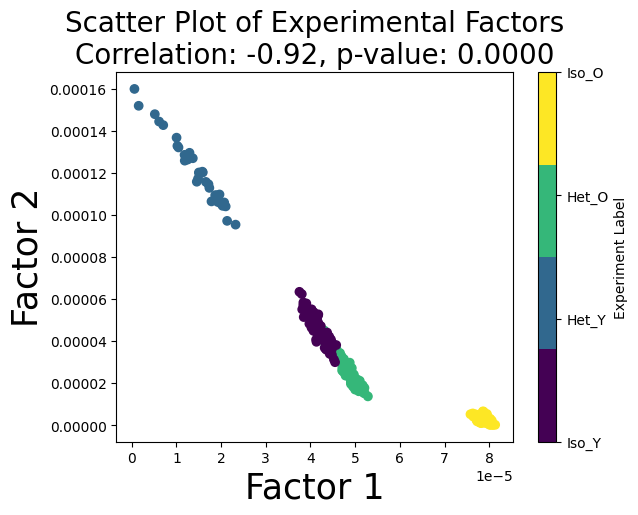

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming you have mode_1_factors_1, mode_1_factors_3, and another vector mode_1_factors_2
# Also assuming you have mapped_numbers with values 0, 1, 2, 3

# Calculate correlation and p-value between the first two mode-2 factors
correlation, p_value = pearsonr(mode_1_factors_1, mode_1_factors_2)

# Create a scatter plot with four distinct colors
fig, ax = plt.subplots()
sc = ax.scatter(mode_1_factors_1, mode_1_factors_2, c=mapped_numbers, cmap=plt.cm.get_cmap('viridis', 4))

# Create a custom color bar with labels
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Iso_Y', 'Het_Y', 'Het_O', 'Iso_O'])
cbar.set_label('Experiment Label')

# Add labels, title, p-value, and adjust font size
ax.set_xlabel('Factor 1', fontsize=25)
ax.set_ylabel('Factor 2', fontsize=25)
ax.set_title(f'Scatter Plot of Experimental Factors\nCorrelation: {correlation:.2f}, p-value: {p_value:.4f}', fontsize=20)

# Show the plot
plt.show()



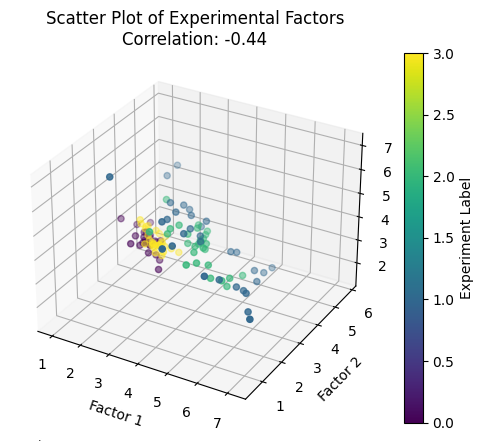

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have mode_1_factors_1, mode_1_factors_2, and another vector mode_1_factors_3

# Calculate correlation and p-value between the first two mode-2 factors
correlation_matrix = np.corrcoef(mode_1_factors_1, mode_1_factors_2, rowvar=False)
correlation = correlation_matrix[0, 1]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot colored by mapped_numbers
sc = ax.scatter(mode_1_factors_1, mode_1_factors_2, mode_1_factors_3, c=mapped_numbers, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Experiment Label')

# Add labels and title
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.set_title(f'Scatter Plot of Experimental Factors\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()


/tmp/ipykernel_145439/2542012502.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sc = plt.scatter(tsne_factor_1_2d, tsne_factor_2_2d, c=mapped_numbers, cmap=plt.cm.get_cmap('viridis', 4), marker='o')


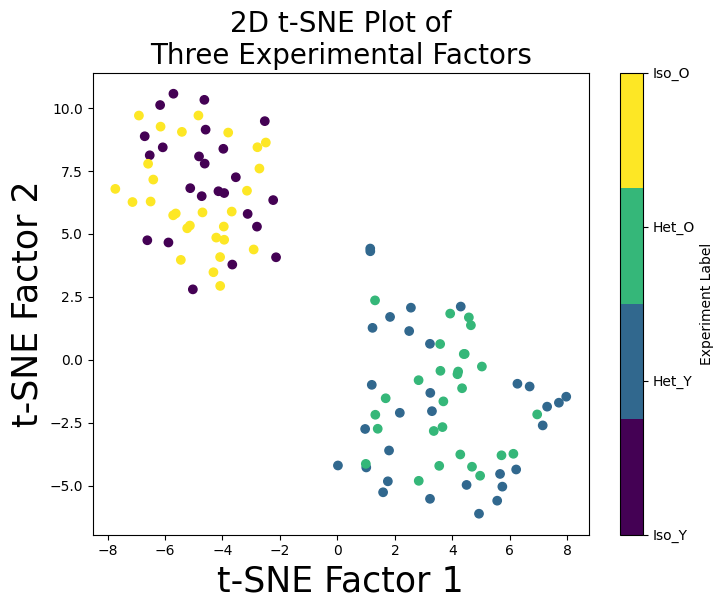

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Assuming you have mode_1_factors_1, mode_1_factors_2, and another vector mode_1_factors_3
# Also assuming you have mapped_numbers with values 0, 1, 2, 3

# Combine the factors into a single array
factors_combined = np.vstack((mode_1_factors_1, mode_1_factors_2, mode_1_factors_3)).T

# Perform t-SNE for 2D
tsne_2d = TSNE(n_components=2, random_state=42)

# Fit and transform the data
factors_2d = tsne_2d.fit_transform(factors_combined)

# Extract the transformed factors for plotting
tsne_factor_1_2d = factors_2d[:, 0]
tsne_factor_2_2d = factors_2d[:, 1]

# Plot 2D t-SNE
plt.figure(figsize=(8, 6))
sc = plt.scatter(tsne_factor_1_2d, tsne_factor_2_2d, c=mapped_numbers, cmap=plt.cm.get_cmap('viridis', 4), marker='o')

# Create a custom color bar with labels
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Iso_Y', 'Het_Y', 'Het_O', 'Iso_O'])
cbar.set_label('Experiment Label')

plt.title('2D t-SNE Plot of\nThree Experimental Factors', fontsize=20)
plt.xlabel('t-SNE Factor 1', fontsize=25)
plt.ylabel('t-SNE Factor 2', fontsize=25)

plt.show()


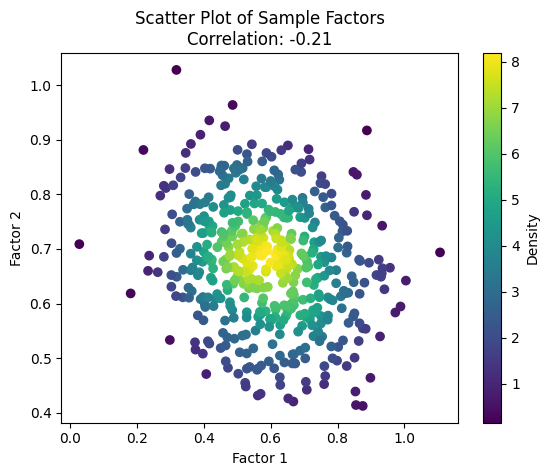

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Calculate correlation and p-value between the first two mode-2 factors
correlation_matrix = np.corrcoef(mode_2_factors_1, mode_2_factors_2, rowvar=False)
correlation = correlation_matrix[0, 1]

# Calculate density values for coloring
xy = np.vstack([mode_2_factors_1, mode_2_factors_2])
density = gaussian_kde(xy)(xy)

# Create a scatter plot colored by density
fig, ax = plt.subplots()
sc = ax.scatter(mode_2_factors_1, mode_2_factors_2, c=density, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Add labels and title
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_title(f'Scatter Plot of Sample Factors\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()



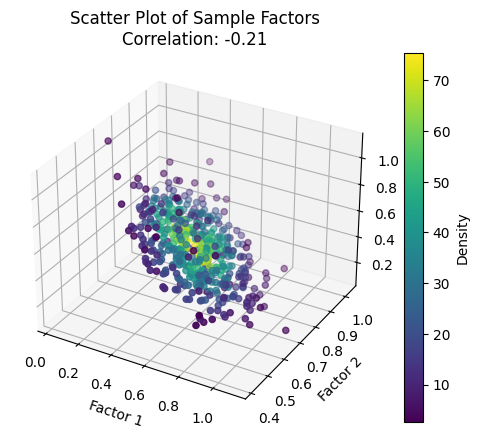

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the Axes3D module
from scipy.stats import gaussian_kde

# Assuming you have three sets of mode-2 factors: mode_2_factors_1, mode_2_factors_2, mode_2_factors_3

# Calculate correlation and p-value between the first two mode-2 factors
correlation_matrix = np.corrcoef(mode_2_factors_1, mode_2_factors_2, rowvar=False)
correlation = correlation_matrix[0, 1]

# Calculate density values for coloring
xyz = np.vstack([mode_2_factors_1, mode_2_factors_2, mode_2_factors_3])
density = gaussian_kde(xyz)(xyz)

# Create a 3D scatter plot colored by density
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use the '3d' projection

sc = ax.scatter(mode_2_factors_1, mode_2_factors_2, mode_2_factors_3, c=density, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Add labels and title
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.set_title(f'Scatter Plot of Sample Factors\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()


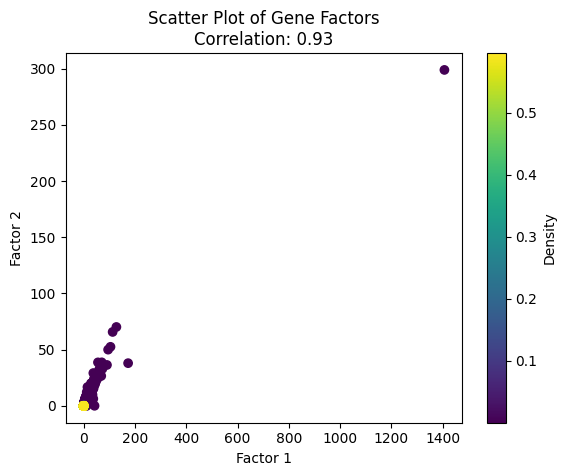

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Calculate correlation and p-value between the first two mode-2 factors
correlation_matrix = np.corrcoef(mode_3_factors_1, mode_3_factors_2, rowvar=False)
correlation = correlation_matrix[0, 1]

# Calculate density values for coloring
xy = np.vstack([mode_3_factors_1, mode_3_factors_2])
density = gaussian_kde(xy)(xy)

# Create a scatter plot colored by density
fig, ax = plt.subplots()
sc = ax.scatter(mode_3_factors_1, mode_3_factors_2, c=density, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Add labels and title
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_title(f'Scatter Plot of Gene Factors\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()



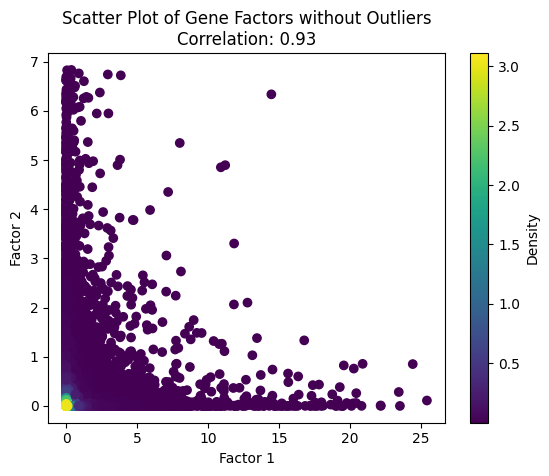

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import zscore

# Assuming you have mode_3_factors_1 and mode_3_factors_2

# Calculate correlation and p-value between the first two mode-2 factors
correlation_matrix = np.corrcoef(mode_3_factors_1, mode_3_factors_2, rowvar=False)
correlation = correlation_matrix[0, 1]

# Calculate Z-scores to identify outliers
z_scores_1 = zscore(mode_3_factors_1)
z_scores_2 = zscore(mode_3_factors_2)

# Define a threshold for considering values as outliers (e.g., z-score > 3)
outlier_threshold = 3

# Filter out outliers
filtered_factors_1 = mode_3_factors_1[abs(z_scores_1) <= outlier_threshold]
filtered_factors_2 = mode_3_factors_2[abs(z_scores_2) <= outlier_threshold]

# Ensure both arrays have the same length
min_length = min(len(filtered_factors_1), len(filtered_factors_2))
filtered_factors_1 = filtered_factors_1[:min_length]
filtered_factors_2 = filtered_factors_2[:min_length]

# Calculate density values for coloring
xy = np.vstack([filtered_factors_1, filtered_factors_2])
density = gaussian_kde(xy)(xy)

# Create a scatter plot colored by density
fig, ax = plt.subplots()
sc = ax.scatter(filtered_factors_1, filtered_factors_2, c=density, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Add labels and title
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_title(f'Scatter Plot of Gene Factors without Outliers\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()


In [126]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the Axes3D module
from scipy.stats import gaussian_kde
from scipy.stats import zscore

# Assuming you have mode_3_factors_1, mode_3_factors_2, and mode_3_factors_3

# Calculate correlation and p-value between the first two mode-2 factors
correlation_matrix = np.corrcoef(mode_3_factors_1, mode_3_factors_2, rowvar=False)
correlation = correlation_matrix[0, 1]

# Calculate Z-scores to identify outliers
z_scores_1 = zscore(mode_3_factors_1)
z_scores_2 = zscore(mode_3_factors_2)
z_scores_3 = zscore(mode_3_factors_3)

# Define a threshold for considering values as outliers (e.g., z-score > 3)
outlier_threshold = 3

# Filter out outliers
filtered_factors_1 = mode_3_factors_1[abs(z_scores_1) <= outlier_threshold]
filtered_factors_2 = mode_3_factors_2[abs(z_scores_2) <= outlier_threshold]
filtered_factors_3 = mode_3_factors_3[abs(z_scores_3) <= outlier_threshold]

# Ensure all arrays have the same length
min_length = min(len(filtered_factors_1), len(filtered_factors_2), len(filtered_factors_3))
filtered_factors_1 = filtered_factors_1[:min_length]
filtered_factors_2 = filtered_factors_2[:min_length]
filtered_factors_3 = filtered_factors_3[:min_length]

# Calculate density values for coloring
xyz = np.vstack([filtered_factors_1, filtered_factors_2, filtered_factors_3])
density = gaussian_kde(xyz)(xyz)

# Create a 3D scatter plot colored by density
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use the '3d' projection

sc = ax.scatter(filtered_factors_1, filtered_factors_2, filtered_factors_3, c=density, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Add labels and title
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.set_title(f'Scatter Plot of Gene Factors without Outliers\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()


NameError: name 'mode_3_factors_4' is not defined

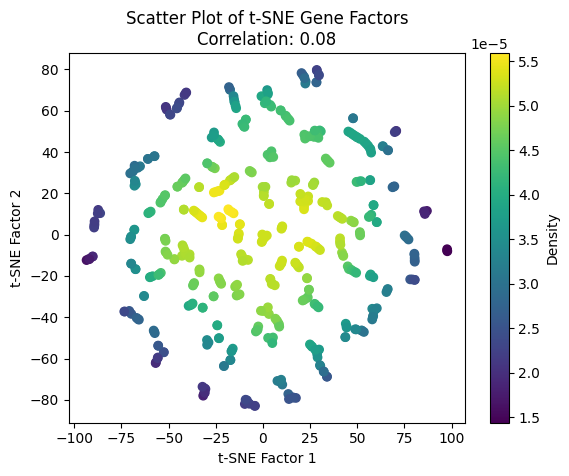

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde

# Assuming you have mode_2_factors_1 and mode_2_factors_2 from NMF
nmf_factors = np.vstack([mode_2_factors_1, mode_2_factors_2, mode_2_factors_3]).T

# Calculate t-SNE of the NMF factors
tsne_factors = TSNE(n_components=2, perplexity=2, random_state=42).fit_transform(nmf_factors)

# Calculate density values for coloring
density = gaussian_kde(tsne_factors.T)(tsne_factors.T)

# Create a scatter plot colored by density
fig, ax = plt.subplots()
sc = ax.scatter(tsne_factors[:, 0], tsne_factors[:, 1], c=density, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Add labels and title
ax.set_xlabel('t-SNE Factor 1')
ax.set_ylabel('t-SNE Factor 2')
ax.set_title(f'Scatter Plot of t-SNE Gene Factors\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def perform_differential_analysis(gene_lengths, gene_values):
    # Combine gene lengths and values into a single array
    gene_data = np.vstack((gene_lengths, gene_values)).T

    # Calculate z-scores to identify and remove outliers
    z_scores = (gene_data - np.mean(gene_data, axis=0)) / np.std(gene_data, axis=0)
    outliers = np.any(np.abs(z_scores) > 3, axis=1)

    # Remove outliers
    gene_data = gene_data[~outliers]

    # Sort genes by values
    sorted_indices = np.argsort(gene_data[:, 1])

    # Extract top and bottom genes
    top_10_genes = gene_data[sorted_indices[-10:]][::-1]
    bottom_10_genes = gene_data[sorted_indices[:10]][::-1]
    top_100_genes = gene_data[sorted_indices[-100:]][::-1]
    bottom_100_genes = gene_data[sorted_indices[:100]][::-1]

    return top_10_genes, bottom_10_genes, top_100_genes, bottom_100_genes

def plot_top_genes(top_genes, title):
    # Extract gene names and values
    gene_names = top_genes[:, 0]
    gene_values = top_genes[:, 1]

    # Plot the top genes in a bar graph
    plt.figure(figsize=(10, 6))
    plt.barh(gene_names, gene_values, color='skyblue')
    plt.xlabel('Gene Values')
    plt.ylabel('Gene Names')
    plt.title(title)
    plt.show()

# Example usage:
# Replace gene_lengths and gene_values with your actual data
gene_lengths = np.random.randint(100, 1000, 100)
gene_values = np.random.rand(100)

top_10_genes, _, _, _ = perform_differential_analysis(gene_lengths, gene_values)
plot_top_genes(top_10_genes, 'Top 10 Genes - Bar Graph')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde

# Assuming you have mode_2_factors_1 and mode_2_factors_2 from NMF
nmf_factors = np.vstack([mode_2_factors_1, mode_2_factors_2, mode_2_factors_3])

# Calculate t-SNE of the NMF factors
tsne_factors = TSNE(n_components=2, perplexity=2, random_state=42).fit_transform(nmf_factors)

# Calculate density values for coloring
density = gaussian_kde(tsne_factors.T)(tsne_factors.T)

# Create a scatter plot colored by density
fig, ax = plt.subplots()
sc = ax.scatter(tsne_factors[:, 0], tsne_factors[:, 1], c=density, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Add labels and title
ax.set_xlabel('t-SNE Factor 1')
ax.set_ylabel('t-SNE Factor 2')
ax.set_title(f'Scatter Plot of t-SNE Factors\nCorrelation: {correlation:.2f}')

# Show the plot
plt.show()


In [103]:
original_dictionary = filtered_datasets

# Integration and normalization
def integrate_and_correct_batch(adata_dict):
    # Concatenate all datasets
    adata_all = sc.AnnData.concatenate(*adata_dict.values(), batch_key='sample', index_unique='_')

    # Normalize the data
    sc.pp.normalize_total(adata_all)

    # Log transform the data
    sc.pp.log1p(adata_all)

    # Perform PCA
    sc.tl.pca(adata_all, n_comps=75)
    
    # Perform batch correction using bbknn
    #bbknn.bbknn(adata_all, batch_key='sample')

    return adata_all

integrated_adata = integrate_and_correct_batch(filtered_datasets)

sample_mapping = {
    '0': 'Iso_Y',
    '1': 'Iso_O',
    '2': 'Het_Y',
    '3': 'Het_O',
}

# Map numeric annotations to labels
integrated_adata.obs['sample'] = integrated_adata.obs['sample'].astype(str).map(sample_mapping)


/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [104]:
integrated_adata.obs

,n_genes,sample
AAACCCAAGAGCTGAC-1_0,5252,Iso_Y
AAACCCAAGCTGTACT-1_0,2300,Iso_Y
AAACCCAAGGAACGAA-1_0,1711,Iso_Y
AAACCCAAGTACTGGG-1_0,1709,Iso_Y
AAACCCAAGTCCCTAA-1_0,1825,Iso_Y
...,...,...
TTTGTTGGTGGCTGAA-1_3,3497,Het_O
TTTGTTGTCAGTCCGG-1_3,968,Het_O
TTTGTTGTCCGGTTCT-1_3,853,Het_O
TTTGTTGTCGCCGAGT-1_3,1388,Het_O


In [105]:
# Perform neighbors with these pcs
sc.pp.neighbors(integrated_adata, n_neighbors=15, use_rep='X_pca')

# make UMPA
sc.tl.umap(integrated_adata)

# Perform Louvain clustering
sc.tl.louvain(integrated_adata, resolution=1.0)

/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'UMAP with Experiment Coloring'}, xlabel='UMAP1', ylabel='UMAP2'>

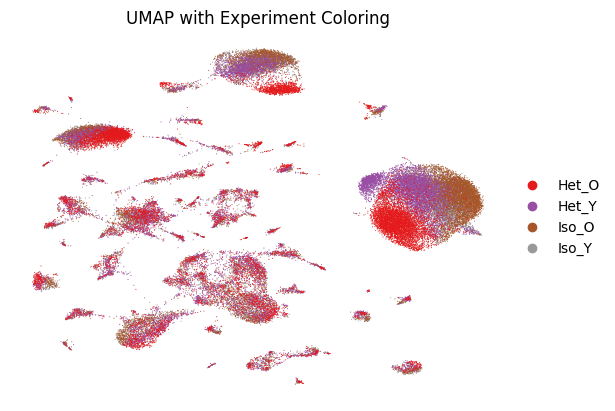

In [122]:
sc.pl.umap(
    integrated_adata,
    color=['sample'],
    legend_loc='right margin',
    palette='Set1',
    frameon=False,
    title=['UMAP with Experiment Coloring'],
    show=False
)


In [ ]:
path = '/home/dwk681/workspace/CRA004660/Liver/'
file_path = path + 'integrated_and_normalized_annData.h5ad'

try:
    integrated_adata.write(file_path)
    print(f"AnnData object successfully saved to: {file_path}")
except Exception as e:
    print(f"Error: {e}")

In [ ]:
integrated_adata.raw = integrated_adata

# Assuming 'Gm42418' and 'AY036118' are in your variable names
genes_of_interest = ['Gm42418', 'AY036118']

# Assuming 'X_umap' is the UMAP coordinates in your AnnData object
umap_coords = integrated_adata.obsm['X_umap']

# Subset the expression matrix for the genes of interest
expression_subset = integrated_adata.X[:, integrated_adata.var_names.isin(genes_of_interest)].A

titles = ['Gm42418 Expression on UMAP', 'AY036118 Expression on UMAP']

# Plot UMAP with expression color-coded
sc.pl.umap(integrated_adata, color=genes_of_interest, use_raw=True, palette='viridis', legend_loc='on data', title=titles)

# Alternatively, you can use matplotlib for a customized plot
#fig, ax = plt.subplots(figsize=(8, 6))
#scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=expression_subset[:, 0], cmap='viridis')
#ax.set_title('Expression of Gm42418 on UMAP')
#ax.set_xlabel('UMAP 1')
#ax.set_ylabel('UMAP 2')
#fig.colorbar(scatter, label='Expression of Gm42418')
#plt.show()

/home/dwk681/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_145439/4237428422.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle, color in zip(legend.legendHandles, legend_colors):


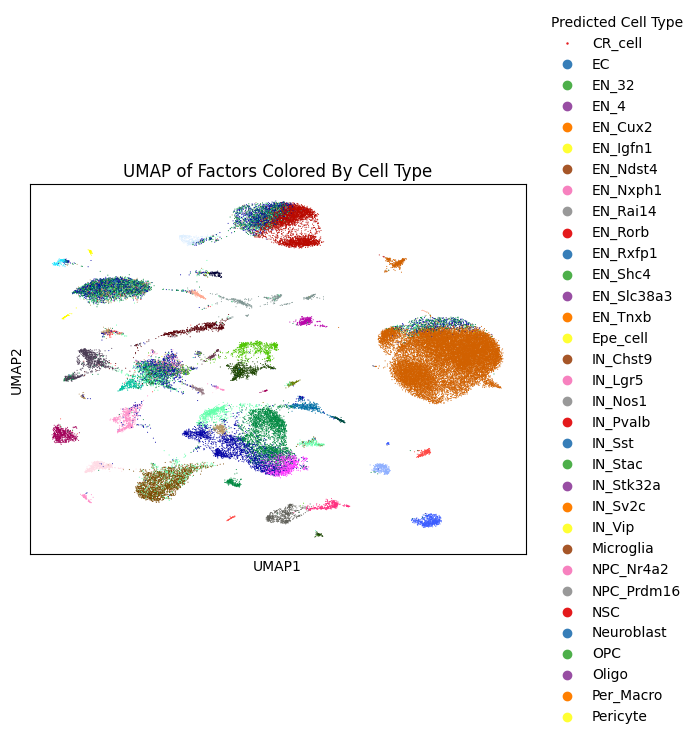

In [108]:
integrated_adata.raw = integrated_adata

# Step 1: Read marker genes from the Excel file
marker_genes_df = pd.read_excel('/home/dwk681/workspace/CRA004660/cannonical_gene_markers.xlsx', sheet_name='Brain', skiprows=1)

# Step 2: Map marker genes to the cell type annotations in your AnnData object
marker_genes_mapping = {}
for _, row in marker_genes_df.iterrows():
    gene = row['Gene']
    cell_type = row['Cell type']
    if gene in integrated_adata.var_names:
        if cell_type not in marker_genes_mapping:
            marker_genes_mapping[cell_type] = []
        marker_genes_mapping[cell_type].append(gene)

# Step 3: Annotate clusters based on marker genes
for cell_type, genes in marker_genes_mapping.items():
    gene_expression = integrated_adata.raw[:, genes].X.mean(axis=1)  # Calculate mean expression across marker genes
    integrated_adata.obs[cell_type] = gene_expression

# Step 4: Classify each sample into the cell type with the highest mean expression
integrated_adata.obs['predicted_cell_type'] = integrated_adata.obs[list(marker_genes_mapping.keys())].idxmax(axis=1)

# Plot UMAP without legend
sc.pl.umap(integrated_adata, color=['predicted_cell_type'], show=False, title = "UMAP of Factors Colored By Cell Type")

# Create a custom legend
legend_labels = list(integrated_adata.obs['predicted_cell_type'].unique())
legend_labels.sort()  # Sort the labels for consistency

legend_colors = sns.color_palette('Set1', n_colors=len(legend_labels))

# Create a legend with only color labels
legend = plt.legend(legend_labels, title='Predicted Cell Type', bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, frameon=False, fontsize=10)

# Set the legend's handles (color patches) to the desired colors
for handle, color in zip(legend.legendHandles, legend_colors):
    handle.set_color(color)

# Show the plot
plt.show()




In [ ]:
sample_key = 'sample'

# Set up the AnnData object for the differential expression analysis
sc.tl.rank_genes_groups(integrated_adata, groupby=sample_key, method='wilcoxon')



In [ ]:
# Initialize a dictionary to store differentially expressed genes for each sample and category
de_genes_dict = {}

# Assuming you want results for all samples
all_samples = integrated_adata.obs[sample_key].unique()

# Loop through samples and retrieve differentially expressed genes
for sample in all_samples:
    result = integrated_adata.uns['rank_genes_groups']
    df_result = result['names'][sample]
    
    # Filter based on adjusted p-value and logFC
    significant_genes_upregulated = df_result[(result['pvals_adj'][sample] < 0.05) & (result['logfoldchanges'][sample] > 0.5)]
    significant_genes_downregulated = df_result[(result['pvals_adj'][sample] < 0.05) & (result['logfoldchanges'][sample] < -0.5)]
    
    # Store the significant genes in lists
    de_genes_dict[f'{sample}_Upregulated'] = list(significant_genes_upregulated)
    de_genes_dict[f'{sample}_Downregulated'] = list(significant_genes_downregulated)

# Print or further analyze the dictionary of differentially expressed genes
for category, de_genes_list in de_genes_dict.items():
    print(f'Differentially expressed genes in category {category}:')
    print(len(de_genes_list))


In [ ]:
# Bar Chart Parameters
figure_file_format = ['png', 'svg']
output_file_name = 'DE_Liver'
color = 'lightskyblue'
final_output_file_names = ['{0}.{1}'.format(output_file_name, file_type) for file_type in figure_file_format]
enrichr_library = 'MSigDB_Hallmark_2020'

gene_list_input_down = de_genes_dict['Het_Y_Downregulated']
genes_downregulated = [x.strip() for x in gene_list_input_down]
gene_list_input_up = de_genes_dict['Het_Y_Upregulated']
genes_upregulated = [x.strip() for x in gene_list_input_up]

# Error handling
class NoResults(Exception):
    pass 
class APIFailure(Exception):
    pass

# Enrichr API Function for Manhattan Plot and Bar Chart
# Takes a gene list and Enrichr libraries as input
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    for library_name in all_libraries : 
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = ''
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)

        if len(data[library_name]) == 0:
            raise NoResults

        short_results_df  = pd.DataFrame(data[library_name][0:5])
        all_terms.append(list(short_results_df[1]))
        all_pvalues.append(list(short_results_df[2]))
        all_adjusted_pvalues.append(list(short_results_df[6]))
        
        results_df  = pd.DataFrame(data[library_name])
        # adds library name to the data frame so the libraries can be distinguished
        results_df['library'] = library_name.replace('_', '')

    return [results_df, short_results_df, all_terms, all_pvalues, all_adjusted_pvalues, str(short_id)]

def enrichr_double_figure(up_terms, up_pvalues, up_adjusted_pvalues, down_terms, down_pvalues, down_adjusted_pvalues, plot_names, all_libraries, up_title, down_title):
    # Set bar colors
    edgecolor=None
    linewidth=0
    up_bar_color =  'lightpink'  #shade of red
    down_bar_color = 'lightskyblue'  #shade of blue
    bar_color_not_sig = 'lightgrey'
    
    plt.figure(figsize=(24, 12))

    # Add a title to the figure
    plt.suptitle("Pathways Regulated By Differentially Expresssed Genes\nHet_Y_Liver", fontsize=40)
    plt.subplots_adjust(top=0.75)
    # Flatten the nested lists of terms
    up_terms_flat = [term for sublist in up_terms for term in sublist]
    down_terms_flat = [term for sublist in down_terms for term in sublist]

    # Flatten the nested lists of p-values
    up_pvalues_flat = [p for sublist in up_pvalues for p in sublist]
    down_pvalues_flat = [p for sublist in down_pvalues for p in sublist]

    # Plot for upregulated genes
    plt.subplot(1, 2, 1)
    up_bar_colors = [up_bar_color if (x < 0.05) else bar_color_not_sig for x in up_pvalues_flat]
    up_fig = sns.barplot(x=np.log10(up_pvalues_flat) * -1, y=up_terms_flat, palette=up_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    up_fig.axes.get_yaxis().set_visible(False)
    up_fig.set_title(up_title, fontsize=30)
    up_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    up_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    up_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(up_pvalues_flat) * -1) < 1:
        up_fig.xaxis.set_ticks(np.arange(0, max(np.log10(up_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(up_terms_flat):
        title_start = max(up_fig.axes.get_xlim()) / 200
        up_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=30)
    up_fig.spines['right'].set_visible(False)
    up_fig.spines['top'].set_visible(False)

    # Plot for downregulated genes
    plt.subplot(1, 2, 2)
    down_bar_colors = [down_bar_color if (x < 0.05) else bar_color_not_sig for x in down_pvalues_flat]
    down_fig = sns.barplot(x=np.log10(down_pvalues_flat) * -1, y=down_terms_flat, palette=down_bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    down_fig.axes.get_yaxis().set_visible(False)
    down_fig.set_title(down_title, fontsize=30)
    down_fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    down_fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    down_fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(down_pvalues_flat) * -1) < 1:
        down_fig.xaxis.set_ticks(np.arange(0, max(np.log10(down_pvalues_flat) * -1), 0.1))
    for ii, annot in enumerate(down_terms_flat):
        title_start = max(down_fig.axes.get_xlim()) / 200
        down_fig.text(title_start, ii, annot, ha='left', wrap=True, fontsize=30)
    down_fig.spines['right'].set_visible(False)
    down_fig.spines['top'].set_visible(False)

    for plot_name in plot_names:
        plt.savefig(plot_name, bbox_inches='tight')

    # Show plot
    plt.show()

    
#Display Bar Chart
caption5 = f"**Figure 1. Bar chart of top enriched terms from the {enrichr_library} gene set library.** The top 5 \
    enriched upregulated and downregulated terms for the input gene set are displayed based on the -log10(p-value)."

try:
    results_upregulated = Enrichr_API(genes_upregulated, [enrichr_library])
    results_downregulated = Enrichr_API(genes_downregulated, [enrichr_library])
    upregulated_title = 'Upregulated Pathways'
    downregulated_title = 'Downregulated Pathways'
    enrichr_double_figure(results_upregulated[2], results_upregulated[3], results_upregulated[4],
                      results_downregulated[2], results_downregulated[3], results_downregulated[4],
                      final_output_file_names, [enrichr_library], upregulated_title, downregulated_title)
    display(Markdown(caption5))
    # Download Bar Chart
    for i, file in enumerate(final_output_file_names):
        display(FileLink(file, result_html_prefix=str('Download ' + figure_file_format[i] + ': ')))
except APIFailure:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because of a bad response from the Enrichr API</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later."))
except NoResults:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, PCA
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

def make_matrix_non_negative(matrix):
    min_val = np.min(matrix)
    if min_val < 0:
        translated_matrix = matrix - min_val
        return translated_matrix
    else:
        return matrix

def plot_nmf_3d(ax, data_matrix, title, max_iter=800):
    # Set the maximum number of iterations for NMF
    nmf_model = NMF(n_components=3, init='random', random_state=42, max_iter=max_iter)
    
    # Fit and transform the data
    nmf_components = nmf_model.fit_transform(data_matrix)
    
    # Calculate correlation and p-value
    corr_coeff, p_value = pearsonr(nmf_components[:, 0], nmf_components[:, 1])
    
    # Format correlation coefficient and p-value
    corr_str = f'Correlation: {corr_coeff:.2f}'
    p_value_str = f'P-value: {p_value:.2f}'
    
    # Calculate kernel density
    kde = gaussian_kde(nmf_components.T)
    density_colors = kde(nmf_components.T)
    
    # Scatter plot with kernel density-based color
    scatter = ax.scatter(
        nmf_components[:, 0], 
        nmf_components[:, 1],
        nmf_components[:, 2], 
        c=density_colors,
        cmap='viridis',
        alpha=0.8
    )
    
    # Include correlation and p-value in the title
    ax.set_title(f'{title}\n{corr_str}\n{p_value_str}', fontsize=30)
    ax.set_xlabel('NMF Component 1', fontsize=20)
    ax.set_ylabel('NMF Component 2', fontsize=20)
    ax.set_zlabel('NMF Component 3', fontsize=20)
    
    # Add colorbar for density
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Density', fontsize=16)

    return scatter

def plot_PCA_3d(ax, data_matrix, title):
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(data_matrix)
    
    # Calculate correlation and p-value
    corr_coeff, p_value = pearsonr(principal_components[:, 0], principal_components[:, 1])
    
    # Format correlation coefficient and p-value
    corr_str = f'Correlation: {corr_coeff:.2f}'
    p_value_str = f'P-value: {p_value:.2f}'
    
    # Calculate kernel density
    kde = gaussian_kde(principal_components.T)
    density_colors = kde(principal_components.T)
    
    # Scatter plot with kernel density-based color
    scatter = ax.scatter(
        principal_components[:, 0], 
        principal_components[:, 1], 
        principal_components[:, 2], 
        c=density_colors,
        cmap='viridis',
        alpha=0.8
    )
    
    # Include correlation and p-value in the title
    ax.set_title(f'{title}\n{corr_str}\n{p_value_str}', fontsize=30)
    ax.set_xlabel('PC 1', fontsize=20)
    ax.set_ylabel('PC 2', fontsize=20)
    ax.set_zlabel('PC 3', fontsize=20)
    
    # Add colorbar for density
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Density', fontsize=16)

    return scatter

data_matrix = integrated_adata.X.toarray()

# Create a single figure with subplots
fig = plt.figure(figsize=(30, 15))

# Create 3D subplots
ax_pca = fig.add_subplot(121, projection='3d')
ax_nmf = fig.add_subplot(122, projection='3d')
       
scatter_pca = plot_PCA_3d(ax_pca, data_matrix, title=f'PCA Plot')
scatter_nmf = plot_nmf_3d(ax_nmf, make_matrix_non_negative(data_matrix), title=f'NMF Plot')
    
# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, PCA
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

def make_matrix_non_negative(matrix):
    min_val = np.min(matrix)
    if min_val < 0:
        translated_matrix = matrix - min_val
        return translated_matrix
    else:
        return matrix

def compute_and_save_nmf(data_matrix, filename, max_iter=100):
    nmf_model = NMF(n_components=2, init='random', random_state=42, max_iter=max_iter)
    nmf_components = nmf_model.fit_transform(data_matrix)
    np.savetxt(filename, nmf_components, delimiter=',')
    return nmf_components

def compute_and_save_pca(data_matrix, filename):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_matrix)
    np.savetxt(filename, principal_components, delimiter=',')
    return principal_components

def plot_scatter(ax, components, title):
    corr_coeff, p_value = pearsonr(components[:, 0], components[:, 1])
    corr_str = f'Correlation: {corr_coeff:.2f}'
    p_value_str = f'P-value: {p_value:.2f}'

    kde = gaussian_kde(components.T)
    density_colors = kde(components.T)

    scatter = ax.scatter(
        components[:, 0], 
        components[:, 1], 
        c=density_colors,
        cmap='viridis',
        alpha=0.8
    )

    ax.set_title(f'{title}\n{corr_str}\n{p_value_str}', fontsize=30)
    ax.set_xlabel('Component 1', fontsize=20)
    ax.set_ylabel('Component 2', fontsize=20)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Density', fontsize=16)

    return scatter


# Example usage:
data_matrix = integrated_adata.X.toarray()

path = '/home/dwk681/workspace/CRA004660/Liver/'

# Compute and save NMF
nmf_components = compute_and_save_nmf(make_matrix_non_negative(data_matrix), path + 'nmf_results.csv')

# Compute and save PCA
pca_components = compute_and_save_pca(data_matrix, path + 'pca_results.csv')

# Plot NMF
fig, ax_nmf = plt.subplots(figsize=(15, 15))
scatter_nmf = plot_scatter(ax_nmf, nmf_components, title='NMF Plot')
plt.show()

# Plot PCA
fig, ax_pca = plt.subplots(figsize=(15, 15))
scatter_pca = plot_scatter(ax_pca, pca_components, title='PCA Plot')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

def make_matrix_non_negative(matrix):
    min_val = np.min(matrix)
    if min_val < 0:
        translated_matrix = matrix - min_val
        return translated_matrix
    else:
        return matrix

def compute_and_save_nmf(data_matrix, filename, max_iter=100):
    nmf_model = NMF(n_components=20, init='random', random_state=42, max_iter=max_iter)
    nmf_factors = nmf_model.fit_transform(data_matrix)
    np.savetxt(filename, nmf_factors, delimiter=',')
    return nmf_factors

def compute_and_save_pca(data_matrix, filename):
    pca = PCA(n_components=20)
    principal_components = pca.fit_transform(data_matrix)
    np.savetxt(filename, principal_components, delimiter=',')
    return principal_components

def plot_tsne(ax, factors_or_components, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(factors_or_components)

    scatter = ax.scatter(
        tsne_result[:, 0], 
        tsne_result[:, 1], 
        alpha=0.8
    )

    ax.set_title(title, fontsize=30)
    ax.set_xlabel('t-SNE Component 1', fontsize=20)
    ax.set_ylabel('t-SNE Component 2', fontsize=20)

    return scatter

# Example usage:
data_matrix = integrated_adata.X.toarray()

path = '/home/dwk681/workspace/CRA004660/Liver/'

# Compute and save NMF
nmf_factors = compute_and_save_nmf(make_matrix_non_negative(data_matrix), path + 'nmf_results.csv')

# Compute and save PCA
pca_components = compute_and_save_pca(data_matrix, path + 'pca_results.csv')

# Plot t-SNE of NMF factors
fig, ax_tsne_nmf = plt.subplots(figsize=(15, 15))
scatter_tsne_nmf = plot_tsne(ax_tsne_nmf, nmf_factors[:, :20], title='t-SNE of NMF Factors')
plt.show()

# Plot t-SNE of PCA components
fig, ax_tsne_pca = plt.subplots(figsize=(15, 15))
scatter_tsne_pca = plot_tsne(ax_tsne_pca, pca_components[:, :20], title='t-SNE of PCA Components')
plt.show()


In [ ]:
import scanpy as sc
import bbknn
import pandas as pd

# Integration and normalization with batch correction on genes
def integrate_and_correct_genes(adata_dict):
    # Concatenate all datasets
    adata_all = sc.AnnData.concatenate(*adata_dict.values(), batch_key='sample', index_unique='_')

    # Normalize the data
    sc.pp.normalize_total(adata_all)

    # Log transform the data
    sc.pp.log1p(adata_all)

    # Perform PCA
    sc.tl.pca(adata_all, n_comps=75)

    # Extract the gene expression matrix for batch correction
    gene_expression = adata_all.X

    # Perform batch correction using bbknn on the gene expression matrix
    bbknn.bbknn(gene_expression, batch_key=adata_all.obsm['sample'])

    # Update the corrected gene expression matrix in the AnnData object
    adata_all.X = gene_expression

    return adata_all

integrated_adata = integrate_and_correct_genes(filtered_datasets)

sample_mapping = {
    '0': 'Iso_Y',
    '1': 'Iso_O',
    '2': 'Het_Y',
    '3': 'Het_O',
}

# Map numeric annotations to labels
integrated_adata.obs['sample'] = integrated_adata.obs['sample'].astype(str).map(sample_mapping)


In [ ]:
# Perform neighbors with these pcs
sc.pp.neighbors(integrated_adata_not, n_neighbors=15, use_rep='X_pca')

# make UMPA
sc.tl.umap(integrated_adata_not)

# Perform Louvain clustering
sc.tl.louvain(integrated_adata_not, resolution=1.0)

# Visualize UMAP and Louvain clustering
titles = ['UMAP with Experiment Coloring']
sc.pl.umap(
    integrated_adata_not,
    color=['sample'],
    legend_loc='on data',
    palette='Set1',
    frameon=False,
    title=titles
)